In [1]:
import copy
import math
from typing import Dict, List, Tuple, Optional
import matplotlib.pyplot as plt
from tabulate import tabulate
import tracemalloc
import sys
import gc
from statistics import mean
import queue 
import ast
import json
import os
import random
import time
import timeit
import pandas as pd

# 1. Problem Formulation Implementation:

In [2]:
class cropNode:
    def __init__(self, state, parent=None, action=None, cost=0):
        self.state = state  # Dictionary of environmental conditions + current crop choice
        self.parent = parent
        self.action = action  # Crop assigned in this step
        self.cost = cost  # Suitability cost (lower = better)
        
        if parent is None:  # Root node
            self.depth = 0
        else:
            self.depth = parent.depth + 1

    def __hash__(self):
        """Create a hash based on the current crop and environmental conditions"""
        return hash((
            self.state['current_crop'],
            frozenset(self.state['soil'].items()),
            frozenset(self.state['climate'].items()),
            frozenset(self.state['environmental'].items())
        ))

    def __eq__(self, other):
        if isinstance(other, cropNode):
            return self.state == other.state 
        return False
    

class CropProblem:
    def __init__(self, initial_state, crop_db, priorities=None):
        """initial_state is of the form:
            {
                'soil': {'n':20.8, 'p':134.2, 'k':199.9, 'ph':5.9, 'organic_matter':5.1, 'soil_moisture':21.2},
                'climate': {'temperature':22.6, 'humidity':92.3, 'rainfall':112.7, 'sunlight_exposure':8.8},
                'environmental': {'irrigation_frequency':3.5, 'water_usage_efficiency':2.8},
                'current_crop': None
            }
        """
        """crop_db is of the form:
            {
                'apple': {
                    'soil': {'n': (0.0, 20.8, 40.0), ...},
                    'climate': {...},
                    'environmental': {...}
                },
                'banana': {
                    'soil': {...},
                    'climate': {...},
                    'environmental': {...}
                },
                ...
            }
        """
        self.state = initial_state 
        self.crop_db = crop_db
        
        if priorities is not None:
            total = sum(priorities.values())
            self.weights = {
                'soil': priorities.get('soil', 1) / total,
                'climate': priorities.get('climate', 1) / total,
                'environmental': priorities.get('environmental', 1) / total
            }
        else:
            # Default equal weights if no priorities provided
            self.weights = {'soil': 0.4, 'climate': 0.3, 'environmental': 0.3}

    def get_valid_actions(self, state):
        """Returns list of valid crop names that match current conditions"""
        valid_crops = []
        for crop_name, reqs in self.crop_db.items():
            if self.is_valid_action(state, reqs):
                valid_crops.append(crop_name)
        return valid_crops

    def is_valid_action(self, state, reqs):
        # Check at least one soil parameter is in range
        if not any(
            reqs['soil'][param][0] <= state['soil'][param] <= reqs['soil'][param][2]
            for param in reqs['soil']
        ):
            return False
        # Check at least one climate parameter is in range
        if not any(
            reqs['climate'][param][0] <= state['climate'][param] <= reqs['climate'][param][2]
            for param in reqs['climate']
        ):
            return False
        # Check at least one environmental parameter is in range
        return any(
            reqs['environmental'][param][0] <= state['environmental'][param] <= reqs['environmental'][param][2]
            for param in reqs['environmental']
        )

    def apply_action(self, state, action):
        """Action is just the crop name (string)"""
        new_state = copy.deepcopy(state)
        new_state['current_crop'] = action
        return new_state
    
    def expand_node(self, node):
        state = node.state
        valid_actions = self.get_valid_actions(state)
        child_nodes = []
        for action in valid_actions:
            child_state = self.apply_action(state, action)
            child_cost = node.cost + self.calculate_cost(node.state, action)
            child_node = cropNode(child_state, parent= node, action = action, cost = child_cost)
            child_nodes.append(child_node)
        return child_nodes

    def calculate_cost(self, state, action):
        """
        Calculate how well the current conditions match a crop's ideal requirements.
        Returns a score where 0 = perfect match, higher values = worse match.
        """
        reqs = self.crop_db[action]
        total_score = 0.0
        
        # Calculate soil suitability (weighted)
        soil_score = self._category_score(state['soil'], reqs['soil'])
        
        # Calculate climate suitability (weighted)
        climate_score = self._category_score(state['climate'], reqs['climate'])
        
        # Calculate environmental suitability (weighted)
        env_score = self._env_score(state['environmental'], reqs['environmental'])
        
        # Combine scores with weights
        total_score = (
            self.weights['soil'] * soil_score + 
            self.weights['climate'] * climate_score + 
            self.weights['environmental'] * env_score
        )
        return total_score

    def _category_score(self, state_values, requirements):
        """Calculate score for one category (soil, climate, etc.)"""
        score = 0.0
        n = 0
        
        for param, (min_val, mean_val, max_val) in requirements.items():
            if param in state_values:
                val = state_values[param]
                range_size = max_val - min_val
                if range_size <= 0:  # Prevent division by zero
                    continue
                
                if val < min_val:
                    param_score = (min_val - val) / range_size
                elif val > max_val:
                    param_score = (val - max_val) / range_size
                else:
                    if val < mean_val:
                        norm_dist = (mean_val - val) / (mean_val - min_val)
                    else:
                        norm_dist = (val - mean_val) / (max_val - mean_val)
                    param_score = norm_dist ** 2  # Quadratic penalty
                
                score += param_score
                n += 1
        
        return math.sqrt(score / n) if n > 0 else 0.0
    
    def _env_score(self, state, parameters):
        """Special scoring for environmental parameters"""
        score = 0.0
        n = 0
        global_min = {}  # Track global min for normalization (if needed)
        # First pass: Find global min for each parameter (if normalizing)
        for param, (min_val, _, max_val) in parameters.items():
            global_min[param] = min_val

        for param, (min_val, _, max_val) in parameters.items():
            if param in state:
                val = state[param]
                if val is not None:
                    range_size = max_val - min_val
                    if range_size <= 0:  # Prevent division by zero
                        continue

                    if val < min_val:
                        # Below minimum - linear penalty since min_val - val > 0
                        param_score = (min_val - val) / range_size
                    elif val > max_val:
                        # Above maximum - linear penalty since val - max_val > 0
                        param_score = (val - max_val) / range_size
                    else:
                        param_score = ((val - min_val) / range_size) ** 2  # Quadratic penalty
                else:        
                    if global_min[param] == 0:
                        # If global_min is 0, just use min_val directly
                        param_score = min_val  # Lower min_val = better (no division needed)
                    else:
                        param_score = min_val / global_min[param]  # Normalized penalty

                score += param_score
                n += 1
        return math.sqrt(score / n) if n > 0 else 0.0

    def print_top_recommendations(self, top_n=5):
        """Print top crop recommendations based on current state"""
        recommendations = [
            (crop, self.calculate_cost(self.state, crop)) 
            for crop in self.get_valid_actions(self.state)
        ]
        
        if not recommendations:
            print("No suitable crops found for current conditions.")
            return
            
        # Normalize scores to 0-1 range
        max_score = max(score for _, score in recommendations)
        normalized_recommendations = [
            (crop, score / max_score) 
            for crop, score in recommendations
        ]
        
        # Sort by score (ascending - lower is better)
        sorted_recommendations = sorted(normalized_recommendations, key=lambda x: x[1])[:top_n]

        print("\n=== TOP CROP RECOMMENDATIONS ===")
        for rank, (crop, norm_score) in enumerate(sorted_recommendations, 1):
            match_percent = 100 * (1 - norm_score)
            print(
                f"{rank}. {crop.capitalize()} - "
                f"Match: {max(0, match_percent):.2f}% "
                f"(Score: {norm_score:.4f})"
            )


# 2. Search Algorithm Techniques:

## 2.1. Genetic Search Algorithm Implementation:

In [3]:
class CropGeneticAlgorithm:
    def __init__(self, problem, population_size=30,  # Increased population size
                 crossover_rate=0.85, mutation_rate=0.25,  # Higher mutation rate
                 elitism_ratio=0.1, max_generations=40):  # More generations
        self.problem = problem
        self.population_size = population_size
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.elitism_ratio = elitism_ratio
        self.max_generations = max_generations
        
    def initialize_population(self) -> List[cropNode]:
        population = []
        valid_crops = self.problem.get_valid_actions(self.problem.state)
        """state is of the form:
            {
                'soil': {'n':20.8, 'p':134.2, 'k':199.9, 'ph':5.9, 'organic_matter':5.1, 'soil_moisture':21.2},
                'climate': {'temperature':22.6, 'humidity':92.3, 'rainfall':112.7, 'sunlight_exposure':8.8},
                'environmental': {'irrigation_frequency':3.5, 'water_usage_efficiency':2.8},
                'current_crop': None
            }
        """
        if not valid_crops:
            raise ValueError("No valid crops available for current conditions")
        for _ in range(self.population_size):
            if random.random() < 0.7:
                crop = random.choice(valid_crops)
            else:
                crop = self.greedy_crop_selection(valid_crops, top_n=3)
                
            state = self.problem.apply_action(self.problem.state, crop)
            cost = self.problem.calculate_cost(state, crop)
            population.append(cropNode(state, action=crop, cost=cost))

        """population is of the form:
            population = [cropNode, cropNode, cropNode, ...]
            and cropNode is of the form:
            cropNode = (state = state, action = apple, cost = 0.15)
            state = {'soil': {'n':20.8, 'p':134.2, 'k':199.9, 'ph':5.9, 'organic_matter':5.1, 'soil_moisture':21.2},
                'climate': {'temperature':22.6, 'humidity':92.3, 'rainfall':112.7, 'sunlight_exposure':8.8},
                'environmental': {'irrigation_frequency':3.5, 'water_usage_efficiency':2.8},
                'current_crop': None }
        """    
        return population
    
    def greedy_crop_selection(self, valid_crops, top_n=3) -> str:
        costs = [(crop, self.problem.calculate_cost(
            self.problem.apply_action(self.problem.state, crop), crop)) 
            for crop in valid_crops]
        costs.sort(key=lambda x: x[1])
        """it will return a randome crop among the best three crops let's assume that it'll 
        return apple"""
        return random.choice(costs[:top_n])[0]
    
    def evaluate_fitness(self, node: cropNode) -> float:
        """Added safeguard against division by zero"""
        return 1 / (1 + node.cost) if node.cost != -1 else 0
    
    def selection(self, population: List[cropNode]) -> Tuple[cropNode, cropNode]:
        tournament = random.sample(population, 3)
        # here we will select random 3 cropNodes from the population returned by
        # the function initialize_population
        tournament.sort(key=lambda x: self.evaluate_fitness(x), reverse=True)
        # here we will sort those 3 cropNodes based on their fitness function from higher to 
        # lower and return the best 2 cropNodes
        return tournament[0], tournament[1]
    
    def crossover(self, parent1: cropNode, parent2: cropNode) -> Tuple[cropNode, cropNode]:
        # parent1 and parent2 are the cropNodes returned by the selection function
        crop1 = parent1.action # this will take the current crop assigned to the conditions entered by the user
        crop2 = parent2.action
        reqs1 = self.problem.crop_db[crop1] # reqs1 are the requirement conditions for that crop which are taken from the database
        reqs2 = self.problem.crop_db[crop2]
        
        blended_reqs = {'soil': {}, 'climate': {}, 'environmental': {}}
        
        for param_type in ['soil', 'climate', 'environmental']:
            for param in reqs1[param_type]:
                min_val = (reqs1[param_type][param][0] + reqs2[param_type][param][0]) / 2
                mean_val = (reqs1[param_type][param][1] + reqs2[param_type][param][1]) / 2
                max_val = (reqs1[param_type][param][2] + reqs2[param_type][param][2]) / 2
                blended_reqs[param_type][param] = (min_val, mean_val, max_val)

        """this will blend the required conditions of the two parents by taking the average
        of the min, mean and the max and assaing them to the blended_reqs which is of the form:
        blended_reqs = {
            'soil' = {'n' = (min, mean, max), ..}
            'climate' = {..}
            'environmental' = {..}
        }
        """
        candidate_crops = []
        for crop, reqs in self.problem.crop_db.items():
            similarity = self.calculate_similarity(reqs, blended_reqs)
            # this will calculate the similarity between the requirements of each crop in our
            # database 'crop_db' and the blended_reqs that we've calculated and create a tuple
            # that has the crop and it's similarity with the blended_reqs and append it to 
            # condidate_crops which is a list of tuples 
            candidate_crops.append((crop, similarity))
            """condidate_crops is of the form: 
                [('apple', 12), ('banana', 10),.. ]
            """
        
        candidate_crops.sort(key=lambda x: x[1], reverse=True)
        # we sort the condidate crops from the crop that has the highest 
        # similarity to the crop that has the lowest one
        top_crops = [crop for crop, _ in candidate_crops[:5]]
        # Select top 5 most similar crops
        
        # if we managed to get more than 2 top crops than we will assign the offsprings
        if len(top_crops) >= 2:
            # we will choose randomly 2 from the top_crops and assign the first one 
            # to offsprint1_crop and the second one to offspring2_crop
            offspring1_crop, offspring2_crop = random.sample(top_crops, 2)
        else:
            # if we have not enough crops than we will select the parents as offsprings
            offspring1_crop, offspring2_crop = crop1, crop2
            
        state1 = self.problem.apply_action(self.problem.state, offspring1_crop)
        state2 = self.problem.apply_action(self.problem.state, offspring2_crop)
        cost1 = self.problem.calculate_cost(state1, offspring1_crop)
        cost2 = self.problem.calculate_cost(state2, offspring2_crop)
        
        return (
            cropNode(state1, action=offspring1_crop, cost=cost1),
            cropNode(state2, action=offspring2_crop, cost=cost2)
        )
    
    def calculate_similarity(self, reqs1, reqs2) -> float:
        similarity = 0.0
        for param_type in ['soil', 'climate', 'environmental']:
            for param in reqs1[param_type]:
                if param in reqs2[param_type]:
                    mean1 = reqs1[param_type][param][1]
                    mean2 = reqs2[param_type][param][1]
                    similarity += 1 / (1 + abs(mean1 - mean2))
        return similarity
    
    def mutate(self, node: cropNode) -> cropNode:
        current_crop = node.action
        valid_crops = self.problem.get_valid_actions(self.problem.state)
        
        if len(valid_crops) <= 1:
            return node
            
        current_reqs = self.problem.crop_db[current_crop]
        similarities = []
        
        for crop in valid_crops:
            if crop != current_crop:
                reqs = self.problem.crop_db[crop]
                similarity = self.calculate_similarity(current_reqs, reqs)
                similarities.append((crop, similarity))
        
        similarities.sort(key=lambda x: x[1], reverse=True)
        
        if similarities:
            if random.random() < (1 - self.mutation_rate) and len(similarities) >= 3:
                new_crop = random.choice(similarities[:3])[0]
            else:
                new_crop = random.choice(similarities)[0]
                
            new_state = self.problem.apply_action(self.problem.state, new_crop)
            new_cost = self.problem.calculate_cost(new_state, new_crop)
            return cropNode(new_state, action=new_crop, cost=new_cost)
        
        return node
    
    def evolve_population(self, population: List[cropNode]) -> List[cropNode]:
        """Combined and corrected version"""
        new_population = []
        
        # Classify suitability first
        for individual in population:
            individual.suitability = self.classify_suitability(individual.cost)
        
        population.sort(key=lambda x: self.evaluate_fitness(x), reverse=True)
        elitism_count = int(self.elitism_ratio * self.population_size)
        new_population.extend(population[:elitism_count])
        
        while len(new_population) < self.population_size:
            parent1, parent2 = self.selection(population)
            
            if random.random() < self.crossover_rate:
                offspring1, offspring2 = self.crossover(parent1, parent2)
            else:
                offspring1, offspring2 = parent1, parent2
            
            if random.random() < self.mutation_rate:
                offspring1 = self.mutate(offspring1)
            if random.random() < self.mutation_rate:
                offspring2 = self.mutate(offspring2)
            
            # Classify offspring
            offspring1.suitability = self.classify_suitability(offspring1.cost)
            offspring2.suitability = self.classify_suitability(offspring2.cost)
            
            new_population.extend([offspring1, offspring2])
            
            if len(new_population) > self.population_size:
                break
                
        return new_population[:self.population_size]
    
    
    def classify_suitability(self, cost: float) -> str:
        if cost < 0.2:
            return "Excellent"
        elif cost < 0.4:
            return "Good"
        elif cost < 0.6:
            return "Fair"
        else:
            return "Poor"

    def run(self):
        """
        Pure genetic search implementation that:
        1. Runs full evolution through all generations
        2. Returns the single best crop found
        3. No early stopping or complex filtering
        """
        population = self.initialize_population()
        
        # Run complete evolution
        for _ in range(self.max_generations):
            population = self.evolve_population(population)
        
        # Find the absolute best crop across all generations
        best_crop = min(population, key=lambda x: x.cost)
        
        return {
            'crop': best_crop.action,
            'cost': best_crop.cost,
            'suitability': self.classify_suitability(best_crop.cost),
            'match_percentage': (1 - best_crop.cost) * 100
        }
    
    def get_top_n_crops(self, n: int = 5) -> List[Dict]:
        """
        Returns top N unique crops from the genetic search
        Preserves your original implementation while adding ranking
        """
        population = self.initialize_population()
        
        # Run full evolution
        for _ in range(self.max_generations):
            population = self.evolve_population(population)
        
        # Get unique crops with their best versions
        unique_crops = {}
        for node in population:
            if node.action not in unique_crops or node.cost < unique_crops[node.action].cost:
                unique_crops[node.action] = node
        
        # Sort by cost and take top N
        sorted_crops = sorted(unique_crops.values(), key=lambda x: x.cost)
        top_n = sorted_crops[:n]
        
        # Format results
        return [{
            'crop': node.action,
            'cost': node.cost,
            'suitability': self.classify_suitability(node.cost),
            'match_percentage': (1 - node.cost) * 100
        } for node in top_n]


## 2.2. General Based On Heuristic Search Algorithms Implementation

In [4]:
BASE_DIR = os.getcwd()
crop_db_path = os.path.join(BASE_DIR, '..', 'data', 'processed', 'crop_db.txt')


class HeuristicCalculator:
    def __init__(self, current_state, crop_db_path , priorities = None):
        if priorities is not None:
            total = sum(priorities.values())
            self.priorities = {
                'soil': priorities.get('soil', 1) / total,
                'climate': priorities.get('climate', 1) / total,
                'environmental': priorities.get('environmental', 1) / total
            }
        else:
            # Default equal weights if no priorities provided
            self.priorities = {'soil': 0.4, 'climate': 0.3, 'environmental': 0.3}
            
        self.current_state = current_state
        self.crop_db = self.load_crop_db(crop_db_path)
        self.heuristics = {}
    def get_valid_crops(self, initial_state):

        problem = CropProblem(self.current_state, self.crop_db)
        return problem.get_valid_actions(self.current_state)

    def heuristic(self, crop):
        crop_conditions = self.crop_db.get(crop, {})
        if not crop_conditions:
            return float('inf')  # If crop or growth stage not found, assign maximum cost
        total_cost = 0

        if 'soil' in self.current_state:
            total_cost += self._compute_general_cost(self.current_state['soil'], crop_conditions.get('soil', {}), use_min=False, category="soil")

        if 'climate' in self.current_state:
            total_cost += self._compute_general_cost(self.current_state['climate'], crop_conditions.get('climate', {}), use_min=False, category="climate")
                
        if 'environmental' in self.current_state:
           total_cost += self._compute_general_cost(self.current_state['environmental'], crop_conditions.get('environmental', {}), use_min=True, category="environmental")           
        
        return total_cost* 0.01 # we multiplied by 0.01 to scale values with costs  
    
    def load_crop_db(self, filepath):
        with open(filepath, 'r') as file:
            data = file.read()
        return ast.literal_eval(data)
    

    def _compute_general_cost(self, actual, ideal, use_min, category):
        total_cost = 0

        for factor, actual_value in actual.items():
            ideal_range = ideal.get(factor)
            if not ideal_range:
                continue

            min_val, mean_val, max_val = ideal_range
            priority = self.priorities.get(category, 0.33)  # default if missing

            target_value = min_val if use_min else mean_val
            range_span = max_val - min_val + 1e-6  # Prevent division by zero

            # Mean Squared Error + soft z-distance
            mse = ((actual_value - target_value) / range_span) ** 2
            z_score = abs(actual_value - mean_val) / (range_span / 4)  # rough std dev

            cost = priority * (mse + z_score)

            # Penalty: out-of-range -> apply power penalty based on distance from boundary
            if actual_value < min_val:
                distance = min_val - actual_value
            elif actual_value > max_val:
                distance = actual_value - max_val
            else:
                distance = 0

            if distance > 0:
                margin = 0.1 * range_span  # Tolerance buffer
                if distance > margin:
                    penalty = priority * ((distance - margin) / range_span)
                    cost += penalty

            # Reward: inside range and close to mean
            if min_val <= actual_value <= max_val:
                normalized_dist = abs(actual_value - mean_val) / (range_span / 2)
                reward = priority * (1 - normalized_dist)
                cost -= reward

            total_cost += cost

        return total_cost

    
    def Heuristics (self, initial_state):
        valid_crops = self.get_valid_crops(self.current_state)
        if not valid_crops:
            print("No valid crops found.")
            return []

        crop_scores = [(crop, self.heuristic( crop)) for crop in valid_crops]
        return crop_scores

    def generate_heuristics(self):
        for crop_name, crop_info in self.Heuristics(self.current_state):
            score = crop_info
            self.heuristics[crop_name] = score

    def save_to_file(self, filepath):
        with open(filepath, 'w') as f:
            f.write(str(self.heuristics))  # Save as string

    def run(self, output_path):
        self.generate_heuristics()
        self.save_to_file(output_path)
        # print(f"Heuristic values saved to: {output_path}")


  
class OrderedNode:
    def __init__(self, node_name , heuristic_value):

        self.heuristic_value = heuristic_value
        self.node_name = node_name

    def __lt__(self, other):  # used by PriorityQueue for comparison
        return self.heuristic_value < other.heuristic_value
    
    def __str__(self):
        return f"( {self.node_name} , {self.heuristic_value} ) "

class GeneralHeuristicBasedSearch:
    
    def __init__(self, problem, heuristics, mode):
        self.problem = problem
        self.heuristicValues = heuristics
        self.mode = mode
        self.initialState = cropNode(self.problem.state)

    def set_frontier(self, node_list, heuristics):
        frontier = queue.PriorityQueue()
        for node in node_list:
            crop_name = node.state['current_crop']
            h_value = heuristics.get(crop_name, float('inf'))

            if self.mode == "a_star":
                g_value = node.cost if hasattr(node, 'cost') else 0  
                f_value = g_value + h_value
            elif self.mode == "greedy":
                f_value = h_value   

            frontier.put(OrderedNode(crop_name, f_value))
        return frontier

    def search(self, cropresults=5):
        frontier = self.set_frontier(self.problem.expand_node(self.initialState), self.heuristicValues)
        result = []

        if not frontier.empty():
            for _ in range(cropresults):
                best_node = frontier.get()
                result.append(best_node)

            return result    
        
        return None, None
    
    def get_top_recommendations(self, top_n=5):
        """get top crop recommendations based on selected search mode (Greedy or A*)"""
        recommendations = []
        child_nodes = self.problem.expand_node(self.initialState)

        for node in child_nodes:
            
            if self.mode == "a_star":
                g_value = node.cost  
                h_value = self.heuristicValues.get(node.action, float('inf'))  
                score = g_value + h_value
            elif self.mode == "greedy":  
                score = self.heuristicValues.get(node.action, float('inf'))

            recommendations.append((node.action, score))

        if not recommendations:
            print("No suitable crops found for current conditions.")
            return

        scores = [score for _, score in recommendations]
        min_score, max_score = min(scores), max(scores)

        if max_score == min_score:
            normalized = [(crop, 0.0) for crop, _ in recommendations]
        else:
            normalized = [(crop, score)for crop, score in recommendations]

        sorted_recommendations = sorted(normalized, key=lambda x: x[1])[:top_n]

        return sorted_recommendations
    
    def print_top_recommendations_using_heuristics(self, top_n=5):
        """Print top crop recommendations based on selected search mode (Greedy or A*)"""
        recommendations = []

        
        child_nodes = self.problem.expand_node(self.initialState)

        for node in child_nodes:
            
            if self.mode == "a_star":
                g_value = node.cost  
                h_value = self.heuristicValues.get(node.action, float('inf'))  
                score = g_value + h_value
            elif self.mode == "greedy":  
                score = self.heuristicValues.get(node.action, float('inf'))

            recommendations.append((node.action, score))

        if not recommendations:
            print("No suitable crops found for current conditions.")
            return

        scores = [score for _, score in recommendations]
        min_score, max_score = min(scores), max(scores)

        if max_score == min_score:
            normalized = [(crop, 0.0) for crop, _ in recommendations]
        else:
            normalized = [(crop, (score) / (max_score)) for crop, score in recommendations]

        sorted_recommendations = sorted(normalized, key=lambda x: x[1])[:top_n]

        print(f"\n=== TOP CROP RECOMMENDATIONS ({self.mode.upper()}) ===")
        for rank, (crop, norm_score) in enumerate(sorted_recommendations, 1):
            match_percent = 100 * (1 - norm_score)
            print(
                f"{rank}. {crop.capitalize()} - "
                f"Match: {max(0, match_percent):.2f}% "
                f"(Score: {norm_score:.4f})"
            )

 

## 2.3. CSP Implemetation

In [5]:
class CropCSP:
    def __init__(self, crop_db: Dict, current_conditions: Dict, 
                 weights: Optional[Dict] = None, tolerance: float = 0.05):
        """
        Complete CSP implementation that shows all options ranked by suitability
        
        Args:
            crop_db: Dictionary of crop requirements
            current_conditions: Current environmental measurements
            weights: Importance weights for categories {'soil': 0.4, ...}
            tolerance: Percentage tolerance for constraints (default: ±5%)
        """
        self.crop_db = crop_db
        self.state = current_conditions
        self.weights = weights or {'soil': 0.4, 'climate': 0.3, 'environmental': 0.3}
        self.tolerance = tolerance
        self.parameter_tolerances = {}

    def set_tolerance(self, tolerance: float):
        """Set global tolerance level"""
        self.tolerance = tolerance

    def set_parameter_tolerance(self, parameter: str, tolerance: float):
        """Set specific tolerance for individual parameters"""
        self.parameter_tolerances[parameter] = tolerance

    def _get_effective_tolerance(self, parameter: str) -> float:
        """Get tolerance for a specific parameter"""
        return self.parameter_tolerances.get(parameter, self.tolerance)

    def _is_in_range_with_tolerance(self, actual: float, min_val: float, 
                                  max_val: float, parameter: str = None) -> bool:
        """Check if value is within tolerated range"""
        if min_val == max_val == 0:
            return actual == 0

        tolerance = self._get_effective_tolerance(parameter)
        
        if parameter == 'water_usage_efficiency':
            return actual >= min_val * (1 - tolerance)
        if parameter == 'pest_pressure':
            return actual <= max_val * (1 + tolerance)
        
        effective_min = min_val * (1 - tolerance)
        effective_max = max_val * (1 + tolerance)
        return effective_min <= actual <= effective_max

    def _check_constraints(self, crop: str) -> Tuple[bool, Dict[str, bool]]:
        """Check constraints and return detailed results"""
        reqs = self.crop_db[crop]
        passes_all = True
        details = {}
        
        for category in ['soil', 'climate', 'environmental']:
            details[category] = {}
            for param in reqs[category]:
                min_val, _, max_val = reqs[category][param]
                actual = self.state[category][param]
                passes = self._is_in_range_with_tolerance(
                    actual, min_val, max_val, f"{category}.{param}"
                )
                details[category][param] = passes
                if not passes:
                    passes_all = False
        
        return passes_all, details

    def _calculate_match_score(self, crop: str) -> float:
        """Calculate weighted suitability score (0=perfect, higher=worse)"""
        reqs = self.crop_db[crop]
        return (
            self.weights['soil'] * self._category_score('soil', reqs) +
            self.weights['climate'] * self._category_score('climate', reqs) +
            self.weights['environmental'] * self._category_score('environmental', reqs)
        )

    def _category_score(self, category: str, reqs: Dict) -> float:
        """Calculate normalized mismatch score for a category"""
        total = 0.0
        n = 0
        
        for param, (min_val, mean_val, max_val) in reqs[category].items():
            actual = self.state[category][param]
            range_size = max_val - min_val
            
            if actual < min_val:
                param_score = (min_val - actual) / range_size
            elif actual > max_val:
                param_score = (actual - max_val) / range_size
            else:
                if actual < mean_val:
                    norm_dist = (mean_val - actual) / (mean_val - min_val)
                else:
                    norm_dist = (actual - mean_val) / (max_val - mean_val)
                param_score = norm_dist ** 2
            
            total += param_score
            n += 1
        
        return math.sqrt(total / n) if n > 0 else 0.0

    def get_all_options(self, top_n: int = 10) -> List[Tuple[str, float, bool, Dict]]:
        """
        Returns all crops ranked by suitability, with constraint info
        
        Returns: List of (crop_name, match_score, passes_constraints, constraint_details)
        """
        results = []
        
        for crop in self.crop_db:
            score = self._calculate_match_score(crop)
            passes, details = self._check_constraints(crop)
            results.append((crop, score, passes, details))
        
        # Sort by match score (lower is better)
        return sorted(results, key=lambda x: x[1])[:top_n]

def print_recommendations(recommendations: List[Tuple[str, float, bool, Dict]]):
    """Print formatted recommendations with constraint status"""
    print("\n=== TOP RECOMMENDATIONS (ALL OPTIONS) ===")
    print("Rank. Crop       Match%  Constraints  Problem Parameters")
    print("------------------------------------------------------")
    
    for rank, (crop, score, passes, details) in enumerate(recommendations, 1):
        match_percent = 100 * (1 - score)
        status = "PASS" if passes else "FAIL"
        
        # Find which parameters failed
        problems = []
        for category in details:
            for param, passed in details[category].items():
                if not passed:
                    problems.append(f"{param}")
        
        problem_str = ", ".join(problems) if problems else "None"
        print(f"{rank:>2}. {crop.capitalize():<10} {match_percent:5.1f}%  {status:<6}  {problem_str}")
   

### Test The Algorithms:

In [6]:
def load_crop_db(file_path):
    """Load crop database from crop_db.txt"""
    with open(file_path, 'r') as f:
        # Read the file content and evaluate it as a Python dictionary
        return eval(f.read())

In [7]:
def main():
    try:
        crop_db = load_crop_db('../data/processed/crop_db.txt')
        
        initial_state = {
            'soil': {
                'n': 110, 'p': 29, 'k': 30,
                'ph': 7, 'organic_matter': 5, 'soil_moisture': 18
            },
            'climate': {
                'temperature': 26, 'humidity': 54,
                'rainfall': 150, 'sunlight_exposure': 7
            },
            'environmental': {
                'irrigation_frequency': 2,
                'water_usage_efficiency': 2,
                'fertilizer_usage': 54,
                'pest_pressure': 1
            },
            'current_crop': None
        }

        problem = CropProblem(initial_state, crop_db)
        
        print("\n=== Genetic Algorithm Output ===")
        ga = CropGeneticAlgorithm(problem)
        
        # Get top N recommendations
        top_n = 5  # Can be changed to any number
        results = ga.get_top_n_crops(top_n)
        
        print(f"\n=== Top {top_n} Genetic Recommendations ===")
        for i, result in enumerate(results, 1):
            print(f"{i}. {result['crop'].capitalize()}:")
            print(f"   - Suitability: {result['suitability']}")
            print(f"   - Cost Score: {result['cost']:.4f}")
            print(f"   - Match Percentage: {result['match_percentage']:.2f}%")

        print("\n=== Greedy and A* Algorithm Output ===")

        calculator = HeuristicCalculator(
            current_state=initial_state,
            crop_db_path= '../data/processed/crop_db.txt'
        )

        calculator.run("../src/utils/heuristics.txt")
        heuristics = load_crop_db("../src/utils/heuristics.txt")
        if not crop_db:
            raise ValueError("Crop database is empty!")
        for crop in crop_db:
            if crop not in heuristics:
                heuristics[crop] = float('inf')  # fallback
                print(f"{crop}crop not in heuristic")

        problem = CropProblem(initial_state, crop_db)
        TryGreedy = GeneralHeuristicBasedSearch(problem, heuristics,"greedy")
        result = TryGreedy.search()
        TryGreedy.print_top_recommendations_using_heuristics()

        Trya_star = GeneralHeuristicBasedSearch(problem, heuristics,"a_star")
        Trya_star.search()
        Trya_star.print_top_recommendations_using_heuristics()

    
        print("\n=== CSP Algorithm Output ===")
        # Initialize solver
        solver = CropCSP(crop_db, initial_state)
        
        # Set custom tolerances if needed
        solver.set_parameter_tolerance('soil.ph', 0.02)  # Stricter pH tolerance
        solver.set_tolerance(0.2)
        
        # Get and display all options
        all_options = solver.get_all_options(top_n=10)
        print_recommendations(all_options)
        
        # Optional: Show only passing options
        passing_options = [x for x in all_options if x[2]]
        if passing_options:
            print("\n=== PASSING OPTIONS ONLY ===")
            print_recommendations(passing_options)
        else:
            print("\nNo options pass all constraints at current tolerance levels")

    except Exception as e:
        print(f"Error: {str(e)}")

if __name__ == "__main__":
    main()


=== Genetic Algorithm Output ===

=== Top 5 Genetic Recommendations ===
1. Coffee:
   - Suitability: Good
   - Cost Score: 0.2563
   - Match Percentage: 74.37%
2. Jute:
   - Suitability: Good
   - Cost Score: 0.3976
   - Match Percentage: 60.24%
3. Pigeonpeas:
   - Suitability: Fair
   - Cost Score: 0.4483
   - Match Percentage: 55.17%
4. Maize:
   - Suitability: Fair
   - Cost Score: 0.4881
   - Match Percentage: 51.19%
5. Mothbeans:
   - Suitability: Fair
   - Cost Score: 0.5349
   - Match Percentage: 46.51%

=== Greedy and A* Algorithm Output ===

=== TOP CROP RECOMMENDATIONS (GREEDY) ===
1. Coffee - Match: 99.79% (Score: 0.0021)
2. Jute - Match: 95.80% (Score: 0.0420)
3. Maize - Match: 95.13% (Score: 0.0487)
4. Pigeonpeas - Match: 94.19% (Score: 0.0581)
5. Cotton - Match: 93.58% (Score: 0.0642)

=== TOP CROP RECOMMENDATIONS (A_STAR) ===
1. Coffee - Match: 92.92% (Score: 0.0708)
2. Jute - Match: 86.61% (Score: 0.1339)
3. Pigeonpeas - Match: 84.23% (Score: 0.1577)
4. Maize - Match: 

# 3. Results & Comparative Analysis:

## 1.  Ability to Find the Most Suitable Crop:


=== Algorithm Comparison ===

Algorithm  Crop                 Predicted       Reference        Score Diff      Penalty   
------------------------------------------------------------------------------------------
Greedy     coffee               0.0049          0.2563           0.2514          0.1508    
Greedy     jute                 0.0967          0.3976           0.3009          0.1805    
Greedy     maize                0.1123          0.4881           0.3758          0.3055    
Greedy     pigeonpeas           0.1338          0.4483           0.3145          0.2687    
Greedy     cotton               0.1479          0.5412           0.3933          0.3160    
------------------------------------------------------------------------------------------
A*         coffee               0.2612          0.2563           0.0049          0.0029    
A*         jute                 0.4943          0.3976           0.0967          0.0580    
A*         pigeonpeas           0.5822          0.4

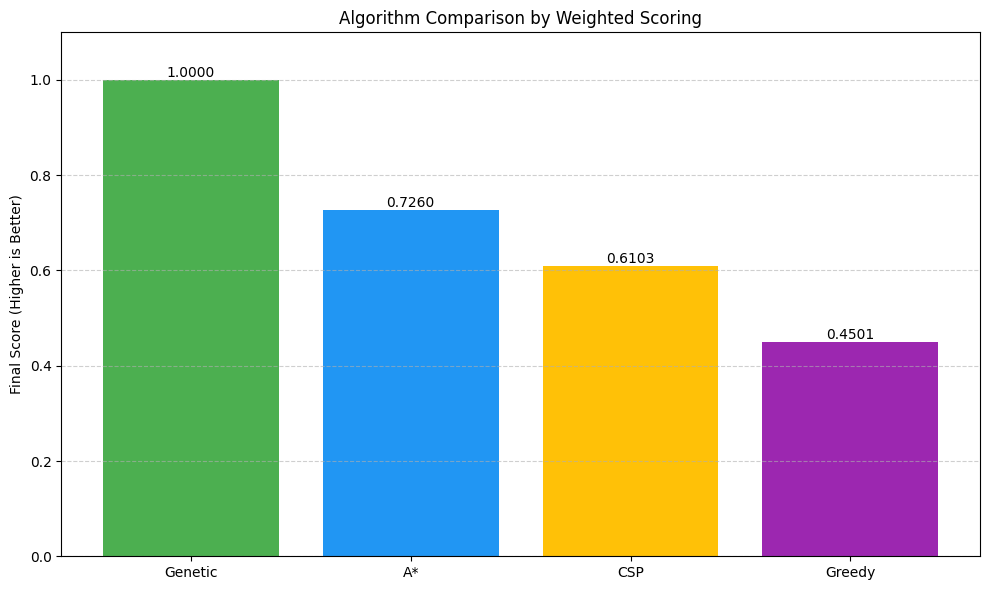

In [8]:

def compare_algorithms(initial_state, crop_db_path, heuristic_path, top_n=5, weight_rank=0.4, weight_score=0.6):
    """
    Compare algorithms using weighted penalty scoring (no alignment comparison)
    
    Parameters:
    - initial_state: Environmental conditions dictionary
    - crop_db_path: Path to crop database file  
    - heuristic_path: Path to save/load heuristics
    - top_n: Number of top crops to compare
    - weight_rank: Importance of ranking position (0-1)
    - weight_score: Importance of score accuracy (0-1)
    """
    
    
    crop_db = load_crop_db(crop_db_path)
    
    
    problem = CropProblem(initial_state, crop_db)
    reference_scores = {crop: problem.calculate_cost(initial_state, crop) 
      for crop in problem.get_valid_actions(initial_state)}
    
    
    ref_ranks = {crop: rank for rank, crop in enumerate(
        sorted(reference_scores.keys(), key=lambda x: reference_scores[x])
    )}
    
    
    calculator = HeuristicCalculator(initial_state, crop_db_path)
    calculator.run(heuristic_path)
    heuristics = load_crop_db(heuristic_path)
    
    
    algorithms = {
        'Greedy': GeneralHeuristicBasedSearch(problem, heuristics, "greedy"),
        'A*': GeneralHeuristicBasedSearch(problem, heuristics, "a_star"),
        'Genetic': CropGeneticAlgorithm(problem),
        'CSP': CropCSP(crop_db, initial_state)
    }
    
    results = {}
    
    print("\n=== Algorithm Comparison ===\n")
    print(f"{'Algorithm':<10} {'Crop':<20} {'Predicted':<15} {'Reference':<15}  {'Score Diff':<15} {'Penalty':<10}")
    print("-" * 90)
    
    for algo_name, algorithm in algorithms.items():
        predictions = []
        
        if algo_name == 'Genetic':
            predictions = [(r['crop'], r['cost']) for r in algorithm.get_top_n_crops(top_n)]
        elif algo_name == 'CSP':
            # Get top_n recommendations from CSP
            csp_results = algorithm.get_all_options(top_n)
            predictions = [(crop, score) for crop, score, _, _ in csp_results]
        else:
            predictions = [(r.node_name, r.heuristic_value) for r in algorithm.search(top_n)]
        
        total_penalty = 0
        algo_results = []
        
        for rank, (crop, pred_score) in enumerate(predictions):
            ref_score = reference_scores.get(crop, 1)  # Default to worst score if not found
            ref_rank = ref_ranks.get(crop, top_n)      # Default to worst rank if not found
            
            score_diff = abs(pred_score - ref_score)
            rank_diff = abs(rank - ref_rank)
            penalty = (weight_score * score_diff) + (weight_rank * (rank_diff/top_n))
            total_penalty += penalty
            
            algo_results.append({
                'crop': crop,
                'predicted': pred_score,
                'reference': ref_score,
                'score_diff': score_diff,
                'penalty': penalty
            })
            
            print(f"{algo_name:<10} {crop:<20} {pred_score:<15.4f} {ref_score:<15.4f}  {score_diff:<15.4f} {penalty:<10.4f}")
        
        
        results[algo_name] = {
            'predictions': algo_results,
            'total_penalty': total_penalty,
            'final_score': 1 / (1 + total_penalty)  # Higher score is better
        }
        print("-" * 90)
    
    # Rank algorithms by their final score
    ranked_algorithms = sorted(results.items(), key=lambda x: x[1]['final_score'], reverse=True)
    
    
    print("\n=== Final Results ===")
    for algo, data in ranked_algorithms:
        print(f"{algo}: Score = {data['final_score']:.4f}, Total Penalty = {data['total_penalty']:.4f}")
    
    # Visualization
    plt.figure(figsize=(10, 6))
    algorithms = [algo for algo, _ in ranked_algorithms]
    scores = [data['final_score'] for _, data in ranked_algorithms]
    
    bars = plt.bar(algorithms, scores, color=['#4CAF50', '#2196F3', '#FFC107', '#9C27B0'])
    plt.title("Algorithm Comparison by Weighted Scoring")
    plt.ylabel("Final Score (Higher is Better)")
    plt.ylim(0, 1.1)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom')
    
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
    
    return {
        'results': results,
        'ranked_algorithms': ranked_algorithms,
        'best_algorithm': ranked_algorithms[0][0]
    }
    
   

def main():
    initial_state = {
            'soil': {
                'n': 110, 'p': 29, 'k': 30,
                'ph': 7, 'organic_matter': 5, 'soil_moisture': 18
            },
            'climate': {
                'temperature': 26, 'humidity': 54,
                'rainfall': 150, 'sunlight_exposure': 7
            },
            'environmental': {
                'irrigation_frequency': 2,
                'water_usage_efficiency': 2,
                'fertilizer_usage': 54,
                'pest_pressure': 1
            },
            'current_crop': None,
            'growth_stage': None
        }

    
    crop_db_path = "../data/processed/crop_db.txt"
    heuristic_path = "../src/utils/heuristics.txt"
    
    compare_algorithms(initial_state, crop_db_path, heuristic_path, top_n=5, weight_rank=0.4, weight_score=0.6)
    

if __name__ == "__main__":
    main()

## 2. Quality of Matches (Environmental Comparison):

Running environmental comparison...


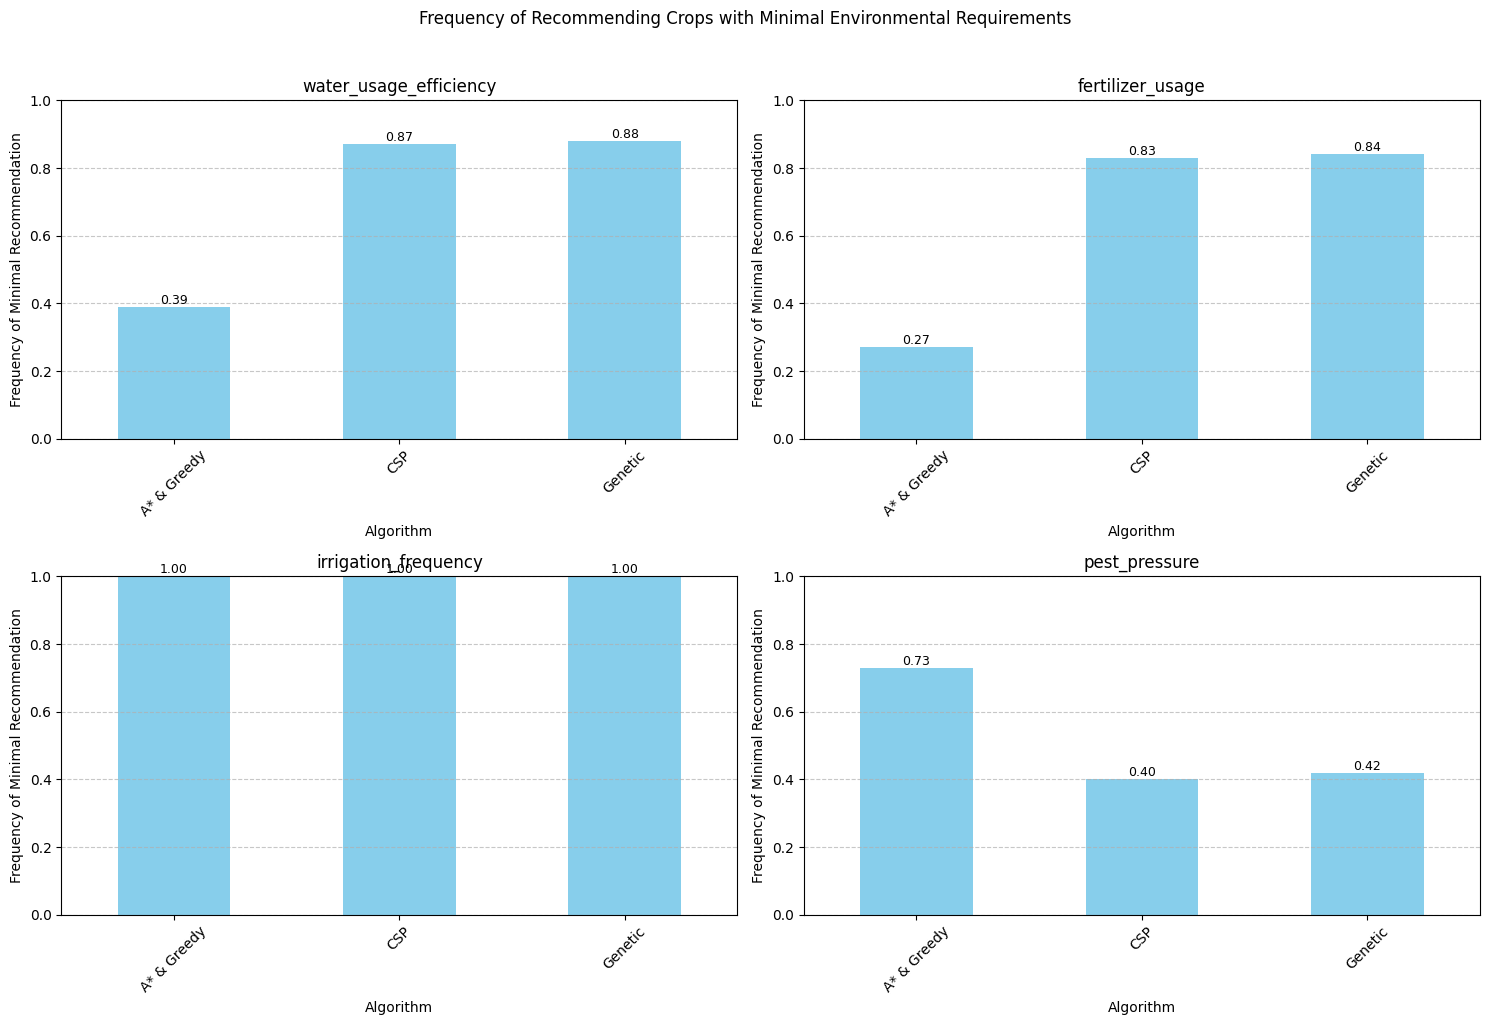


Environmental Comparison Table:

+-----------------------------+------------------------+------------------+----------------------+---------------+
|                             | water_usage_efficiency | fertilizer_usage | irrigation_frequency | pest_pressure |
+-----------------------------+------------------------+------------------+----------------------+---------------+
| GeneralHeuristicBasedSearch |          0.39          |       0.27       |         1.0          |     0.73      |
|           CropCSP           |          0.87          |       0.83       |         1.0          |      0.4      |
|    CropGeneticAlgorithm     |          0.88          |       0.84       |         1.0          |     0.42      |
+-----------------------------+------------------------+------------------+----------------------+---------------+


In [9]:
class EnvironmentalImpactEvaluator:

    def __init__(self,problem):
        self.problem = problem
        self.environmental_factors = [
            'water_usage_efficiency',
            'fertilizer_usage',
            'irrigation_frequency', 
            'pest_pressure'
        ]
        self.factor_weights = {
            'water_usage_efficiency': 0.25,
            'fertilizer_usage': 0.25,
            'irrigation_frequency': 0.25, 
            'pest_pressure': 0.25
        }
    
    def evaluate_algorithm(self, algorithm, conditions, top_n=10):
        """Evaluate an algorithm's recommendations for environmental impact"""
        crop_db = load_crop_db('../data/processed/crop_db.txt')
        heuristics = load_crop_db("../src/utils/heuristics.txt")

        problem = CropProblem(conditions, crop_db)
        recommendations = []
        if algorithm == GeneralHeuristicBasedSearch:
            
            search_greedy = GeneralHeuristicBasedSearch(problem,heuristics,"greedy")
            recommendation = search_greedy.get_top_recommendations(top_n)
            recommendations =  [t[0] for t in recommendation ]
            
            search_a_star =  GeneralHeuristicBasedSearch(problem,heuristics,"a_star")
            recommendation = search_a_star.get_top_recommendations(top_n)
            recommendations =  [t[0] for t in recommendation ]
            
        elif algorithm == CropCSP:
            csp = CropCSP(crop_db,conditions)
            recommendation = csp.get_all_options(top_n)
            recommendations = [ t[0] for t in recommendation ]
           
        elif algorithm == CropGeneticAlgorithm:
            ga = CropGeneticAlgorithm(problem)
            recommendation = ga.get_top_n_crops(top_n)
            recommendations = [ item["crop"] for item in recommendation ]
        


        if not recommendations:
            return None
        
        return {
            'algorithm': algorithm.__name__,
            'conditions': conditions,
            'recommendations': [rec for rec in recommendations],
            
        }
    
def compare_algorithm_environmental_impact(scenarios, crop_db, algorithms):
    """
    Compare environmental parameters of best crops recommended by each algorithm.
    Scores each algorithm based on how often it recommends crops with minimal environmental requirements.
    
    Args:
        scenarios (list): List of scenario dictionaries
        crop_db (dict): The crop database dictionary
        algorithms (list): List of algorithm functions to compare
        evaluator: EnvironmentalImpactEvaluator instance
    """
    # Initialize storage for environmental parameters
    parameters = evaluator.environmental_factors
    env_scores = {algo.__name__: {param: 0 for param in parameters} for algo in algorithms}
    scenario_counts = {algo.__name__: 0 for algo in algorithms}  # Track successful scenarios per algorithm
    
    for scenario in scenarios:
        # Store best (minimum) values for each parameter in this scenario
        min_values = {param: None for param in parameters}
        algo_recommendations = {}
        
        # First pass: Get all recommendations and find global minimums
        for algo in algorithms:
            try:
                # Get algorithm recommendations
                scenario_results = evaluator.evaluate_algorithm(algo, scenario, top_n=1)
                
                if scenario_results and scenario_results['recommendations']:
                    best_crop = scenario_results['recommendations'][0]
                    scenario_counts[algo.__name__] += 1
                    algo_recommendations[algo.__name__] = best_crop
                    
                    # Track minimum values for each parameter
                    if best_crop in crop_db:
                        for param in parameters:
                            if param in crop_db[best_crop]['environmental']:
                                min_val = crop_db[best_crop]['environmental'][param][0]
                                if min_values[param] is None or min_val < min_values[param]:
                                    min_values[param] = min_val
            except Exception as e:
                print(f"Error processing {algo.__name__} for scenario: {e}")
                continue
        
        # Second pass: Compare each algorithm's recommendations to the minimums
        for algo_name, best_crop in algo_recommendations.items():
            if best_crop in crop_db:
                for param in parameters:
                    if param in crop_db[best_crop]['environmental']:
                        algo_min_val = crop_db[best_crop]['environmental'][param][0]
                        # Use a tolerance for floating-point comparison
                        if abs(algo_min_val - min_values[param]) < 1e-6:
                            env_scores[algo_name][param] += 1
        
    # Convert to DataFrame
    comparison_df = pd.DataFrame.from_dict(env_scores, orient='index')
    comparison_df = comparison_df.astype(float)
    
    # Normalize scores by number of scenarios each algorithm completed
    
    for algo_name in comparison_df.index:
        if scenario_counts[algo_name] > 0:
            comparison_df.loc[algo_name] = comparison_df.loc[algo_name] / scenario_counts[algo_name]
    
    # Plot each parameter in a separate subplot with values on bars
    num_params = len(parameters)
    cols = 2
    rows = (num_params + cols - 1) // cols


    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    fig.suptitle('Frequency of Recommending Crops with Minimal Environmental Requirements', y=1.02)
    axes = axes.flatten()

    for i, param in enumerate(parameters):
        ax = axes[i]
        bars = comparison_df[param].plot(kind='bar', ax=ax, color='skyblue')
        ax.set_title(param)
        ax.set_ylabel('Frequency of Minimal Recommendation')
        ax.set_xlabel('Algorithm')
        ax.set_ylim(0, 1)  # Since these are frequencies
        
        # Rename algorithm labels for better readability
        new_labels = {
            
            'CropCSP': 'CSP',
            'CropGeneticAlgorithm': 'Genetic',
            'GeneralHeuristicBasedSearch': 'A* & Greedy'
        }
        current_labels = [label.get_text() for label in ax.get_xticklabels()]
        updated_labels = [new_labels.get(name, name) for name in current_labels]
        ax.set_xticklabels(updated_labels)
        ax.tick_params(axis='x', rotation=45)
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Add values on top of each bar
        for bar in bars.patches:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}',
                    ha='center', va='bottom', fontsize=9)

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.savefig('algorithm_minimal_environmental_recommendations.png')
    plt.show()

    print("\nEnvironmental Comparison Table:\n")
    print(tabulate(comparison_df, headers='keys', tablefmt='pretty', floatfmt=".3f"))
    return comparison_df
    

def generate_random_agricultural_data():
    #Generate random agricultural data with realistic ranges
    return {
        'soil': {
            'n': round(random.uniform(10.0, 200.0), 1),  
            'p': round(random.uniform(5.0, 150.0), 1),   
            'k': round(random.uniform(20.0, 300.0), 1),  
            'ph': round(random.uniform(4.5, 8.5), 1),    
            'organic_matter': round(random.uniform(1.0, 10.0)), 
            'soil_moisture': round(random.uniform(5.0, 35.0)),  
        },
        'climate': {
            'temperature': round(random.uniform(10.0, 40.0), 1),  
            'humidity': round(random.uniform(30.0, 95.0)),  
            'rainfall': round(random.uniform(0.0, 50.0)),  
            'sunlight_exposure': round(random.uniform(4.0, 14.0)),  
        },
        'environmental': {
            'irrigation_frequency': random.uniform(1.0, 10.0),  
            'water_usage_efficiency': round(random.uniform(1.0, 10.0)),  
            'fertilizer_usage': round(random.uniform(5.0, 200.0)),  
            'pest_pressure': round(random.uniform(0.0, 100.0)),  
        },
        'current_crop': None,
        'growth_stage': None
    }
    



if __name__ == "__main__":
    
    random.seed(81)
    # 1. Define algorithms to compare
    
    algorithms = [GeneralHeuristicBasedSearch,CropCSP,CropGeneticAlgorithm ]
    scenarios = []
    # 2. Generate environmental scenarios
    for _ in range(100):
        scenarios.append(generate_random_agricultural_data())
    
    
    # 3. Initialize evaluator
    crop_db = load_crop_db('../data/processed/crop_db.txt')
    problem = CropProblem(scenarios,crop_db)
    evaluator = EnvironmentalImpactEvaluator(problem)
    
    # 4. Run comparison
    print("Running environmental comparison...")
    env_comparison = compare_algorithm_environmental_impact(scenarios, crop_db, algorithms)
    

## 3. Computational Efficiency:

### 3.1. Comparison in terms of Time Complexity:


=== RUNNING TIME COMPLEXITY BENCHMARKS ===
Running genetic algorithm...
Running a_star algorithm...
Running greedy algorithm...
Running csp algorithm...

=== EXECUTION TIME RESULTS ===
+-------------+-----------------+----------------+
| Algorithm   |   Avg Time (ms) |   Result Count |
+=============+=================+================+
| CSP         |            1.48 |              5 |
+-------------+-----------------+----------------+
| A_STAR      |            9.02 |              5 |
+-------------+-----------------+----------------+
| GREEDY      |           20.84 |              5 |
+-------------+-----------------+----------------+
| GENETIC     |          210.39 |              5 |
+-------------+-----------------+----------------+

Generating time comparison graph...


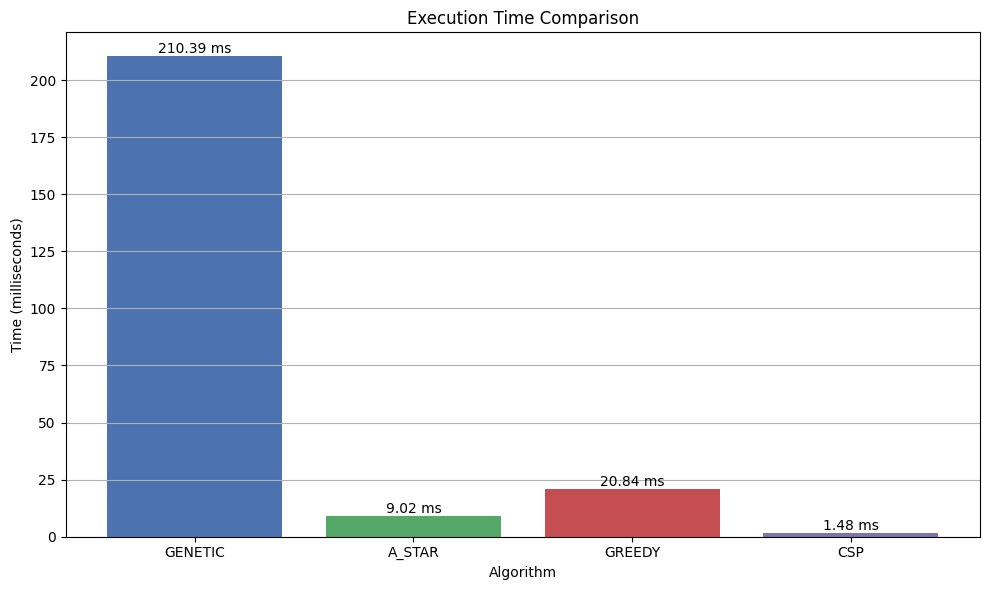

In [27]:


class TimeComplexityBenchmark:
    
    def __init__(self, problem, runs=3, warmup=1):
        self.problem = problem
        self.results = []
        self.runs = runs  
        self.warmup = warmup
        self.crop_db = load_crop_db(crop_db_path)
    def _measure_algorithm(self, algorithm_name, **kwargs):
        """Measure execution time over multiple runs"""
        measurements = []
        results = []
        
       
        for _ in range(self.warmup):
            if algorithm_name == 'genetic':
                algo = CropGeneticAlgorithm(self.problem, **kwargs)
                _ = algo.get_top_n_crops(5)
            elif algorithm_name in ['a_star', 'greedy']:
                calculator = HeuristicCalculator(
                    current_state=self.problem.state,
                    crop_db_path='../data/processed/crop_db.txt'
                )
                calculator.run("../src/utils/heuristics.txt")
                heuristics = load_crop_db("../src/utils/heuristics.txt")
                algo = GeneralHeuristicBasedSearch(self.problem, heuristics, algorithm_name)
                _ = algo.search(5)
            elif algorithm_name == 'csp':
                algo = CropCSP(self.problem.crop_db, self.problem.state, **kwargs)
                _ = algo.get_all_options(5)
        
        # Measurement phase
        for _ in range(self.runs):
            gc.collect()
            
            try:
                start_time = timeit.default_timer()
                
                if algorithm_name == 'genetic':
                    algo = CropGeneticAlgorithm(self.problem, **kwargs)
                    result = algo.get_top_n_crops(5)
                elif algorithm_name in ['a_star', 'greedy']:
                    calculator = HeuristicCalculator(
                        current_state=self.problem.state,
                        crop_db_path='../data/processed/crop_db.txt'
                    )
                    calculator.run("../src/utils/heuristics.txt")
                    heuristics = load_crop_db("../src/utils/heuristics.txt")
                    algo = GeneralHeuristicBasedSearch(self.problem, heuristics, algorithm_name)
                    result = algo.search(5)
                elif algorithm_name == 'csp':
                    algo = CropCSP(self.problem.crop_db, self.problem.state, **kwargs)
                    result = algo.get_all_options(5)
                
                elapsed = timeit.default_timer() - start_time
                measurements.append(elapsed)
                results.append(result)
                
            except Exception as e:
                print(f"Error running {algorithm_name}: {str(e)}")
                measurements.append(0)
                results.append(None)
        
        # Store average measurements
        avg_time_ms = mean(measurements) * 1000 if measurements else 0
        
        self.results.append({
            'algorithm': algorithm_name.upper(),
            'time_ms': avg_time_ms,
            'result': results[0] if results else None,
            'runs': self.runs
        })
        
        return avg_time_ms

    def generate_results_table(self):
        """Generate formatted results table"""
        table_data = []
        headers = ["Algorithm", "Avg Time (ms)", "Result Count"]
        
        for result in sorted(self.results, key=lambda x: x['time_ms']):
            table_data.append([
                result['algorithm'],
                f"{result['time_ms']:.2f}",
                len(result['result']) if result['result'] else 0
            ])
        
        return tabulate(table_data, headers=headers, tablefmt="grid")

    def plot_time_comparison(self):
        """Plot time usage comparison"""
        algorithms = [r['algorithm'] for r in self.results]
        times = [r['time_ms'] for r in self.results]
        
        plt.figure(figsize=(10, 6))
        bars = plt.bar(algorithms, times, color=['#4C72B0', '#55A868', '#C44E52', '#8172B2'])
        plt.title("Execution Time Comparison")
        plt.xlabel("Algorithm")
        plt.ylabel("Time (milliseconds)")
        
        # Add value labels
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f} ms',
                    ha='center', va='bottom')
        
        plt.grid(True, axis='y')
        plt.tight_layout()
        plt.savefig("execution_time_comparison.png")
        plt.show()

    def analyze(self):
        """Run complete analysis"""
        print("\n=== RUNNING TIME COMPLEXITY BENCHMARKS ===")
        self.run_benchmarks()
        
        print("\n=== EXECUTION TIME RESULTS ===")
        print(self.generate_results_table())
        
        print("\nGenerating time comparison graph...")
        self.plot_time_comparison()

    def run_benchmarks(self):
        """Run all algorithms and collect time metrics"""
        algorithms = ['genetic', 'a_star', 'greedy', 'csp']
        
        for name in algorithms:
            print(f"Running {name} algorithm...")
            try:
                self._measure_algorithm(name)
            except Exception as e:
                print(f"Error running {name}: {str(e)}")
                self.results.append({
                    'algorithm': name.upper(),
                    'time_ms': 0,
                    'result': None,
                    'runs': self.runs
                })
               

# Example Usage
if __name__ == "__main__":
    # Example initial state (same as in your space complexity example)
    initial_state = {
        'soil': {
            'n': 100.2, 'p': 82.0, 'k': 50.0,
            'ph': 6.0, 'organic_matter': 5.8,
            'soil_moisture': 20.4
        },
        'climate': {
            'temperature': 27.0, 'humidity': 80.0,
            'rainfall': 110.0, 'sunlight_exposure': 9.0
        },
        'environmental': {
            'irrigation_frequency': 3.0,
            'water_usage_efficiency': 3.0,
            'fertilizer_usage': 120.0,
            'pest_pressure': 50.0
        }
    }
    
    # Load your crop DB (replace with actual path)
    crop_db = load_crop_db('../data/processed/crop_db.txt')  
    problem = CropProblem(initial_state, crop_db)
    
    benchmark = TimeComplexityBenchmark(problem, runs=5, warmup=1)
    benchmark.analyze()

### 3.2. Comparison In Terms Of Space Complexity:


=== RUNNING MEMORY BENCHMARKS ===
Running genetic algorithm...
Running a_star algorithm...
Running greedy algorithm...
Running csp algorithm...

=== MEMORY USAGE RESULTS ===
+-------------+--------------------+-----------------------+----------------+
| Algorithm   |   Peak Memory (KB) |   Result Size (bytes) |   Result Count |
+=============+====================+=======================+================+
| CSP         |              20.15 |                    96 |              5 |
+-------------+--------------------+-----------------------+----------------+
| GENETIC     |             161.02 |                   120 |              5 |
+-------------+--------------------+-----------------------+----------------+
| GREEDY      |            1844.82 |                   120 |              5 |
+-------------+--------------------+-----------------------+----------------+
| A_STAR      |            1845.09 |                   120 |              5 |
+-------------+--------------------+---------

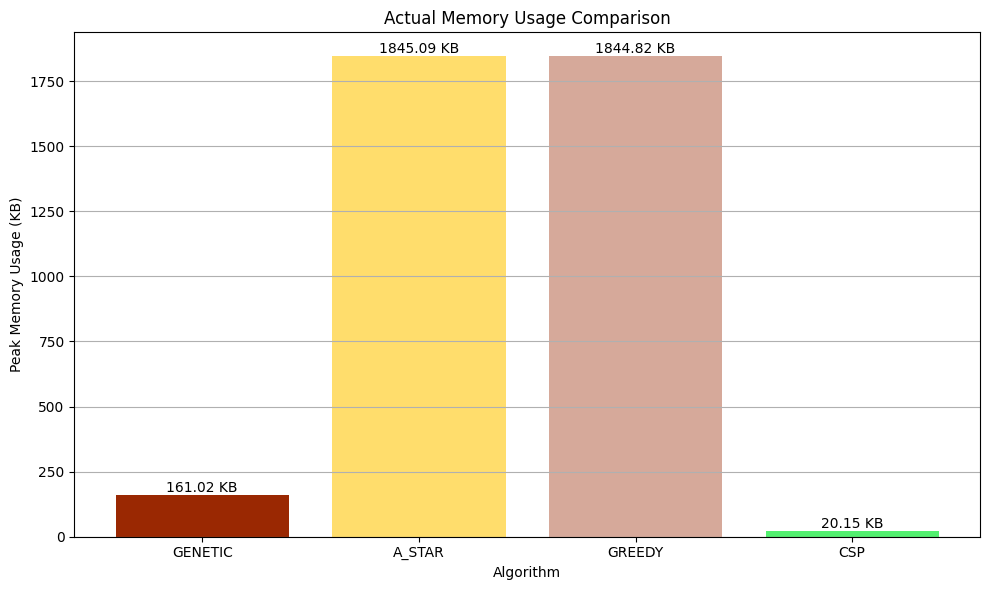

In [26]:
class SpaceComplexityBenchmark:
    def __init__(self, problem, runs=3):
        self.problem = problem
        self.results = []
        self.runs = runs  # Store runs as instance variable

    def _measure_algorithm(self, algorithm_name, **kwargs):
        """Measure average peak memory usage over multiple runs"""
        """Peak Memory refers to the maximum amount of RAM (memory) consumed by an algorithm 
        while it is executing. It represents the highest point of memory usage during 
        the program's runtime."""
        measurements = []
        result_sizes = []
        results = []
        
        for _ in range(self.runs):
            # Clean up before measurement
            gc.collect()
            
            tracemalloc.start()
            
            try:
                if algorithm_name == 'genetic':
                    algo = CropGeneticAlgorithm(self.problem, **kwargs)
                    result = algo.get_top_n_crops(5)
                elif algorithm_name in ['a_star', 'greedy']:
                    calculator = HeuristicCalculator(
                        current_state=self.problem.state,
                        crop_db_path='../data/processed/crop_db.txt'
                    )
                    calculator.run("../src/utils/heuristics.txt")
                    heuristics = load_crop_db("../src/utils/heuristics.txt")
                    algo = GeneralHeuristicBasedSearch(self.problem, heuristics, algorithm_name)
                    result = algo.search(5)
                elif algorithm_name == 'csp':
                    algo = CropCSP(self.problem.crop_db, self.problem.state, **kwargs)
                    result = algo.get_all_options(5)
                
                # Get memory stats
                current, peak = tracemalloc.get_traced_memory()
                measurements.append(peak)
                result_sizes.append(sys.getsizeof(result))
                results.append(result)
                
            except Exception as e:
                print(f"Error running {algorithm_name}: {str(e)}")
                measurements.append(0)
                result_sizes.append(0)
                results.append(None)
                
            finally:
                tracemalloc.stop()
        
        # Store average measurements
        avg_peak_kb = mean(measurements) / 1024 if measurements else 0
        avg_result_size = mean(result_sizes) if result_sizes else 0
        
        self.results.append({
            'algorithm': algorithm_name.upper(),
            'peak_memory_kb': avg_peak_kb,
            'result_size': avg_result_size,
            'result': results[0] if results else None,
            'runs': self.runs  # Include runs count in results
        })
        
        return avg_peak_kb

    def generate_results_table(self):
        """Generate formatted results table"""
        table_data = []
        headers = ["Algorithm", "Peak Memory (KB)", "Result Size (bytes)", "Result Count"]
        
        for result in sorted(self.results, key=lambda x: x['peak_memory_kb']):
            table_data.append([
                result['algorithm'],
                f"{result['peak_memory_kb']:.2f}",
                result['result_size'],
                len(result['result']) if result['result'] else 0
            ])
        
        return tabulate(table_data, headers=headers, tablefmt="grid")

    def plot_memory_comparison(self):
        """Plot memory usage comparison"""
        algorithms = [r['algorithm'] for r in self.results]
        memory = [r['peak_memory_kb'] for r in self.results]
        
        plt.figure(figsize=(10, 6))
        bars = plt.bar(algorithms, memory, color=['#9A2802', '#FFDD6C', '#D6A99A', '#52F06F'])
        plt.title("Actual Memory Usage Comparison")
        plt.xlabel("Algorithm")
        plt.ylabel("Peak Memory Usage (KB)")
        
        # Add value labels
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f} KB',
                    ha='center', va='bottom')
        
        plt.grid(True, axis='y')
        plt.tight_layout()
        plt.savefig("actual_memory_usage.png")
        plt.show()

    def analyze(self):
        """Run complete analysis"""
        print("\n=== RUNNING MEMORY BENCHMARKS ===")
        self.run_benchmarks()
        
        print("\n=== MEMORY USAGE RESULTS ===")
        print(self.generate_results_table())
        
        print("\nGenerating memory comparison graph...")
        self.plot_memory_comparison()

    def run_benchmarks(self):
        """Run all algorithms and collect memory metrics"""
        algorithms = ['genetic', 'a_star', 'greedy', 'csp']
        
        for name in algorithms:
            print(f"Running {name} algorithm...")
            try:
                self._measure_algorithm(name)
            except Exception as e:
                print(f"Error running {name}: {str(e)}")
                self.results.append({
                    'algorithm': name.upper(),
                    'peak_memory_kb': 0,
                    'result_size': 0,
                    'result': None,
                    'runs': self.runs
                })

# Example Usage
if __name__ == "__main__":
    # Example initial state (replace with your actual state)
    initial_state = {
        'soil': {
            'n': 100.2, 'p': 82.0, 'k': 50.0,
            'ph': 6.0, 'organic_matter': 5.8,
            'soil_moisture': 20.4
        },
        'climate': {
            'temperature': 27.0, 'humidity': 80.0,
            'rainfall': 110.0, 'sunlight_exposure': 9.0
        },
        'environmental': {
            'irrigation_frequency': 3.0,
            'water_usage_efficiency': 3.0,
            'fertilizer_usage': 120.0,
            'pest_pressure': 50.0
        }
    }
    
    # Load your crop DB (replace with actual path)
    crop_db = load_crop_db('../data/processed/crop_db.txt')  # Load your actual crop DB here
    problem = CropProblem(initial_state, crop_db)
    
    benchmark = SpaceComplexityBenchmark(problem)
    benchmark.analyze()